In [1]:
# Import required libraries

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# yfinance returns data for all strikes for a single expiration at a time. It’s easier to work with all strikes and expirations at the same time so write a function to combine the expirations.

def option_chains(ticker):
    """
    This function first gets all the expirations. 
    Then it loops through each expiration and gets the option chain. 
    It adds a column for option type, changes the expiration date to be at the end of the day, 
    combines each option chain together in a DataFrame.
    Computes the number of days until expiration
    """
    asset = yf.Ticker(ticker)
    expirations = asset.options
    
    chains = pd.DataFrame()
    
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)
        
        calls = opt.calls
        calls['optionType'] = "call"
        
        puts = opt.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

In [3]:
# Download the data and get the call options. 

options = option_chains("SPY")

calls = options[options["optionType"] == "call"]

In [4]:
# pick an expiration so you can plot the volatility skew.

# print the expirations
set(calls.expiration)

{Timestamp('2022-12-19 23:59:59'),
 Timestamp('2022-12-20 23:59:59'),
 Timestamp('2022-12-21 23:59:59'),
 Timestamp('2022-12-22 23:59:59'),
 Timestamp('2022-12-23 23:59:59'),
 Timestamp('2022-12-27 23:59:59'),
 Timestamp('2022-12-28 23:59:59'),
 Timestamp('2022-12-29 23:59:59'),
 Timestamp('2022-12-30 23:59:59'),
 Timestamp('2023-01-06 23:59:59'),
 Timestamp('2023-01-13 23:59:59'),
 Timestamp('2023-01-20 23:59:59'),
 Timestamp('2023-01-27 23:59:59'),
 Timestamp('2023-02-17 23:59:59'),
 Timestamp('2023-03-17 23:59:59'),
 Timestamp('2023-03-31 23:59:59'),
 Timestamp('2023-04-21 23:59:59'),
 Timestamp('2023-06-16 23:59:59'),
 Timestamp('2023-06-30 23:59:59'),
 Timestamp('2023-09-15 23:59:59'),
 Timestamp('2023-09-29 23:59:59'),
 Timestamp('2023-12-15 23:59:59'),
 Timestamp('2024-01-19 23:59:59'),
 Timestamp('2024-06-21 23:59:59'),
 Timestamp('2024-12-20 23:59:59'),
 Timestamp('2025-01-17 23:59:59'),
 Timestamp('2025-03-21 23:59:59')}

In [5]:
# select an expiration to plot
calls_at_expiry = calls[calls["expiration"] == "2023-01-20 23:59:59"]

In [6]:
# filter out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]

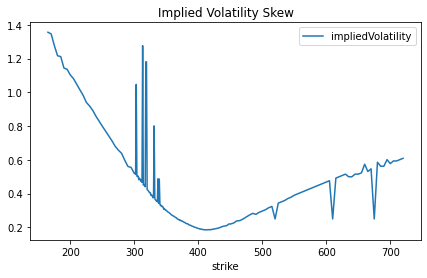

In [7]:
# set the strike as the index so pandas plots nicely
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
    title="Implied Volatility Skew", figsize=(7, 4)
);

# Save the figure.
plt.savefig("./Images/ImpliedVolatilitySkew.jpg")

In [8]:
# build a volatility term structure. Pick a strike price to plot by expiration.

# select an expiration to plot
calls_at_strike = options[options["strike"] == 400.0]

In [9]:
# filter out low vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]

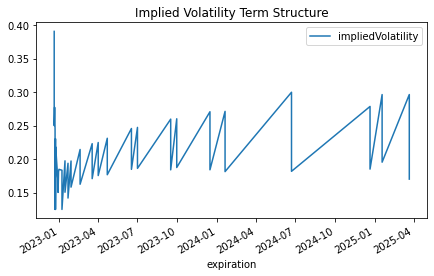

In [10]:
# set the strike as the index so pandas plots nicely
filtered_calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(
    title="Implied Volatility Term Structure", figsize=(7, 4)
);

# Save the figure.
plt.savefig("./Images/ImpliedVolatilityTermStructure.jpg")

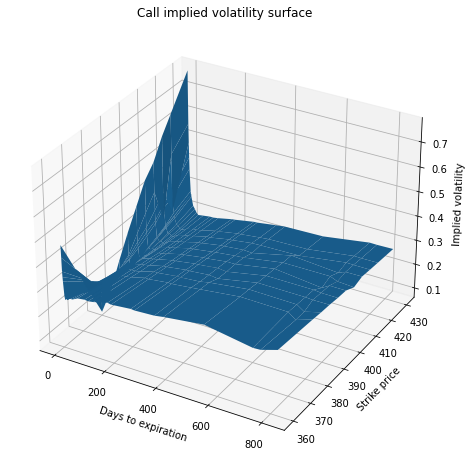

In [11]:
# Plot a volatility surface

# pivot the dataframe
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 8))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

# plot
ax.plot_surface(X, Y, z)

# Save the figure.
plt.savefig("./Images/ImpliedVolatilitySurface.jpg")